.. index:: Methods; Adaptive Finite Elements

.. index:: Equations; Poisson Problem

# Re-entrant Corner Problem

Here we will consider the classic _re-entrant corner_ problem,
\begin{align*}
-\Delta u &= f, && \text{in } \Omega, \\
u &= g, && \text{on } \partial\Omega,
\end{align*}
where the domain is given using polar coordinates,
\begin{gather*}
\Omega = \{ (r,\varphi)\colon r\in(0,1), \varphi\in(0,\Phi) \}~.
\end{gather*}
For the boundary condition $g$, we set it to the trace of the function $u$, given by
\begin{gather*}
u(r,\varphi) = r^{\frac{\pi}{\Phi}} \sin\big(\frac{\pi}{\Phi} \varphi \big)
\end{gather*}

In [1]:
import numpy
import matplotlib.pyplot as pyplot
from dune.fem.plotting import plotPointData as plot
import dune.grid as grid
import dune.fem as fem
from dune.fem.view import adaptiveLeafGridView as adaptiveGridView
from dune.fem.space import lagrange as solutionSpace
from dune.alugrid import aluConformGrid as leafGridView
from dune.fem.function import gridFunction
from dune.fem import integrate
from dune.fem import GridMarker
from ufl import *
try:
    from ufl import atan2
except ImportError: # remain compatible with version 2022 of ufl
    from ufl import atan_2 as atan2

from dune.ufl import DirichletBC

from functools import partial
from dune.common import comm
# print can be used in parallel runs as before but will only produce output on rank 0
print = partial(print, flush=True) if comm.rank == 0 else lambda *args, **kwargs: None

# set the angle for the corner (0<angle<=360)
cornerAngle = 320.

# use a second order space
order = 2

We first define the domain and set up the grid and space.
We need this twice - once for a computation on a globally refined grid
and once for an adaptive one so we put the setup into a function:

We first define the grid for this domain (vertices are the origin and 4
equally spaced points on the unit sphere starting with (1,0) and
ending at (cos(cornerAngle), sin(cornerAngle))

Next we define the model together with the exact solution.



In [2]:
def setup():
    vertices = numpy.zeros((8, 2))
    vertices[0] = [0, 0]
    for i in range(0, 7):
        vertices[i+1] = [numpy.cos(cornerAngle/6*numpy.pi/180*i),
                         numpy.sin(cornerAngle/6*numpy.pi/180*i)]
    triangles = numpy.array([[2,1,0], [0,3,2], [4,3,0],
                             [0,5,4], [6,5,0], [0,7,6]])
    domain = {"vertices": vertices, "simplices": triangles}
    gridView = adaptiveGridView( leafGridView(domain) )
    gridView.hierarchicalGrid.globalRefine(2)
    space = solutionSpace(gridView, order=order, storage="numpy")

    from dune.fem.scheme import galerkin as solutionScheme
    u = TrialFunction(space)
    v = TestFunction(space)
    x = SpatialCoordinate(space)

    # exact solution for this angle
    Phi = cornerAngle / 180 * pi
    phi = atan2(x[1], x[0]) + conditional(x[1] < 0, 2*pi, 0)
    exact = dot(x, x)**(pi/2/Phi) * sin(pi/Phi * phi)
    a = dot(grad(u), grad(v)) * dx

    # set up the scheme
    laplace = solutionScheme([a==0, DirichletBC(space, exact, 1)], solver="cg",
                parameters={"linear.preconditioning.method":"jacobi"})
    uh = space.interpolate([0], name="solution")
    return uh, exact, laplace

We will start with computing the $H^1$ error on a sequence of globally
refined grids

Note that by using `fem.globalRefine` instead of
`hierarchicalGrid.globalRefine` we can prolongate discrete functions
to the next level. The second argument can also be a list/tuple
of discrete functions to prolong. With this approach we obtain a good
initial guess for solving the problem on the refined grid.

In [3]:
uh, exact, laplace = setup()
h1error = gridFunction(dot(grad(uh - exact), grad(uh - exact)))
errorGlobal = []
dofsGlobal  = []
for count in range(10):
    laplace.solve(target=uh)
    error = numpy.sqrt(integrate(h1error, order=5))
    errorGlobal += [error]
    dofsGlobal  += [uh.space.size]
    print(count, ": size=", uh.space.gridView.size(0), "error=", error)
    fem.globalRefine(1,uh)

0 : size= 32 error= 0.18655122279356978


1 : size= 68 error= 0.16034368267325266


2 : size= 144 error= 0.1255494881561846


3 : size= 296 error= 0.10825248980058116


4 : size= 608 error= 0.08486347007964641


5 : size= 1232 error= 0.07320710422512636


6 : size= 2496 error= 0.05741715963356527


7 : size= 5024 error= 0.04954133581605676


8 : size= 10112 error= 0.03886429530584708


9 : size= 20288 error= 0.03353671438408606


Theory tells us that
\begin{align*}
\int_\Omega |\nabla(u-u_h)|^2 \leq \sum_K \eta_K,
\end{align*}
where on each element $K$ of the grid the local estimator is given by
\begin{align*}
\eta_K = h_K^2 \int_K |\triangle u_h|^2 +
\frac{1}{2}\sum_{S\subset \partial K} h_S \int_S [\nabla u_h]^2.
\end{align*}
Here $[\cdot]$ is the jump in normal direction over the edges of the grid.

We compute the elementwise indicator by defining a bilinear form
\begin{align*}
\eta(u,v) = \int_\Omega h^2 |\triangle u_h|^2 v + \int_{I_h} h_S [\nabla u_h]^2 \{v\},
\end{align*}
where $\{\cdot\}$ is the average over the cell edges and $[\cdot]$
the jump. With $h$ and $h_S$ we denote local grid spacings and with
$I_h$ the set of all facets in the grid.
This bilinear form can be easily written in UFL and by using it to
define a discrete operator $L$ from the second order Lagrange space into a space containing piecewise constant functions
we have $L[u_h]|_{K} = \eta_K$.

In [4]:
uh, exact, laplace = setup()

from dune.fem.space import finiteVolume as estimatorSpace
from dune.fem.operator import galerkin as estimatorOp

fvspace = estimatorSpace(uh.space.gridView)
estimate = fvspace.interpolate([0], name="estimate")

u = TrialFunction(uh.space)
v = TestFunction(fvspace)
hT = MaxCellEdgeLength(fvspace)
he = MaxFacetEdgeLength(fvspace)('+')
n = FacetNormal(fvspace)
estimator_ufl = hT**2 * (div(grad(u)))**2 * v * dx +        he * inner(jump(grad(u)), n('+'))**2 * avg(v) * dS
estimator = estimatorOp(estimator_ufl)
tolerance = 0.05

.. index:: Adaptation; Doerfler marking

Let us solve over a loop (solve,estimate,mark) and plot the solutions side by side.

2 : size= 38 estimate= 0.8627288181776043 error= 0.13430895435402315


5 : size= 60 estimate= 0.6093716379873615 error= 0.0815341425097061


8 : size= 74 estimate= 0.4767178417377045 error= 0.055215517740272


11 : size= 112 estimate= 0.3431156913697979 error= 0.03741185673883578


14 : size= 174 estimate= 0.20313335323949364 error= 0.022993934028895862


17 : size= 316 estimate= 0.11427960569600788 error= 0.013551254946383456


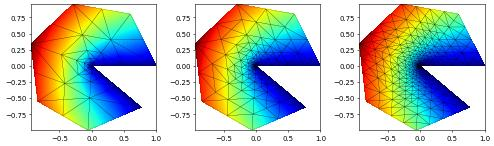

In [5]:
h1error = gridFunction(dot(grad(uh - exact), grad(uh - exact)))
fig = pyplot.figure(figsize=(10,10))
count = 0
errorVector    = []
estimateVector = []
dofs           = []

marker = GridMarker( estimate, # grid function to be evaluated at cell center
                     0.6,                    # refinement tolerance
                     strategy = 'doerfler',  # marking strategy doerfler
                     layered = 0.1)          # parameter for Doerfler layered strategy.


while True:
    laplace.solve(target=uh)
    if count%9 == 8:
        plot(uh, figure=(fig, 131+count//9), colorbar=False)
    error = numpy.sqrt(integrate(h1error, order=5))
    estimator(uh, estimate)
    eta = numpy.sqrt( sum(estimate.dofVector) )
    dofs           += [uh.space.size]
    errorVector    += [error]
    estimateVector += [eta]
    if count%3 == 2:
        print(count, ": size=", uh.space.gridView.size(0), "estimate=", eta, "error=", error)
    if eta < tolerance:
        break

    fem.gridAdapt(marker, uh) # can also be a list or tuple of function to prolong/restrict
    count += 1
plot(uh, figure=(fig, 131+2), colorbar=False)

Let's have a look at the center of the domain:

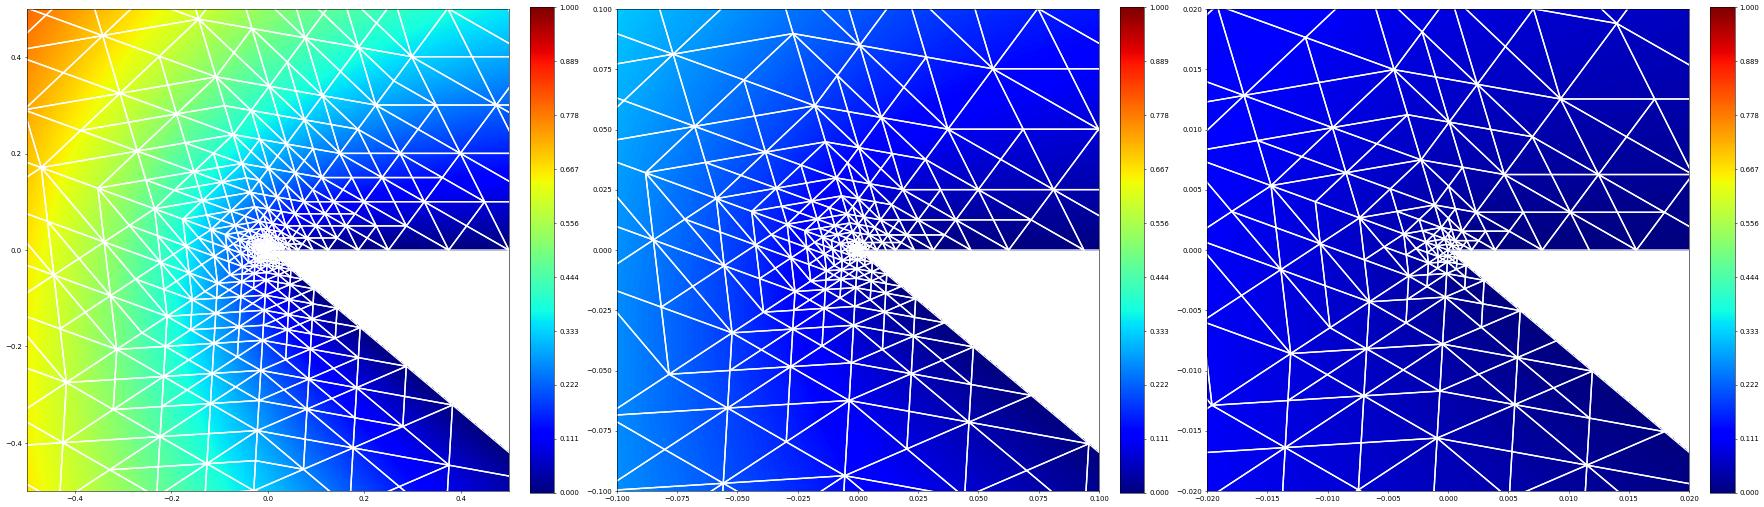

In [6]:
pyplot.close('all')
fig = pyplot.figure(figsize=(35,15))
plot(uh, figure=(fig, 131), xlim=(-0.5, 0.5), ylim=(-0.5, 0.5),
        gridLines="white", colorbar={"shrink": 0.75}, linewidth=2)
plot(uh, figure=(fig, 132), xlim=(-0.1, 0.1), ylim=(-0.1, 0.1),
        gridLines="white", colorbar={"shrink": 0.75}, linewidth=2)
plot(uh, figure=(fig, 133), xlim=(-0.02, 0.02), ylim=(-0.02, 0.02),
        gridLines="white", colorbar={"shrink": 0.75}, linewidth=2)

We can also visualize the grid levels used

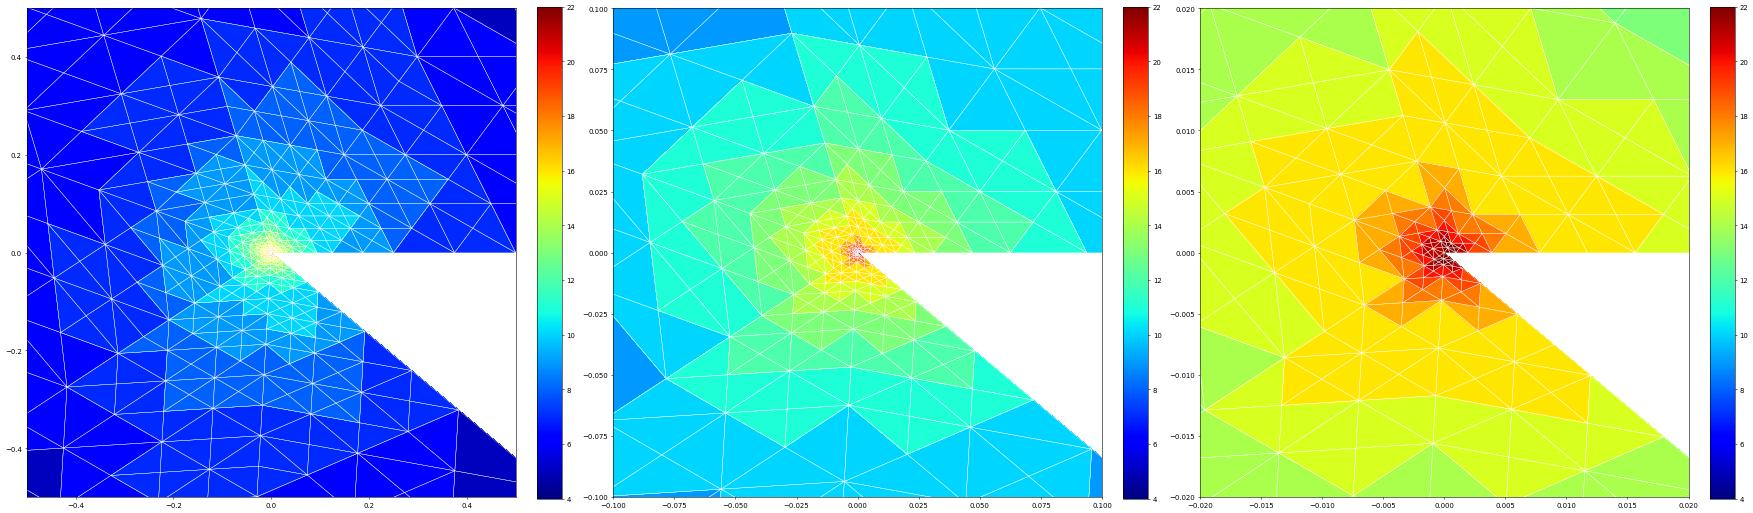

In [7]:
fig = pyplot.figure(figsize=(35,15))
from dune.fem.function import levelFunction
levels = levelFunction(uh.space.gridView)
plot(levels, figure=(fig, 131), xlim=(-0.5, 0.5), ylim=(-0.5, 0.5),
        gridLines="white", colorbar={"shrink": 0.75}, linewidth=0.5)
plot(levels, figure=(fig, 132), xlim=(-0.1, 0.1), ylim=(-0.1, 0.1),
        gridLines="white", colorbar={"shrink": 0.75}, linewidth=0.5)
plot(levels, figure=(fig, 133), xlim=(-0.02, 0.02), ylim=(-0.02, 0.02),
        gridLines="white", colorbar={"shrink": 0.75}, linewidth=0.5)

Finally, let us compare the globally refined solution and the adaptive
one plotting number of degrees of freedom versus the error and the
estimator

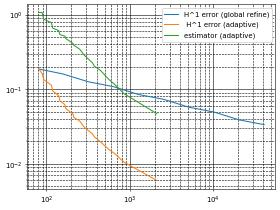

In [8]:
pyplot.close('all')
pyplot.loglog(dofsGlobal,errorGlobal,label="H^1 error (global refine)")
pyplot.loglog(dofs,errorVector,label=" H^1 error (adaptive)")
pyplot.loglog(dofs,estimateVector,label="estimator (adaptive)")
pyplot.grid(visible=True, which='major', color='black', linestyle='-')
pyplot.grid(visible=True, which='minor', color='black', linestyle='--')
pyplot.legend(frameon=True,facecolor="white",framealpha=1)